In [1]:
import pickle
import numpy as np
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import utils
from random import choices
from omnifold import omnifold as of
import tensorflow as tf
import tensorflow.keras.backend as K
# Enable eager execution
tf.config.run_functions_eagerly(True)
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.layers import Dense, Input, Concatenate
from keras.models import Model
import torch
from torch.utils.data import Dataset
from torch.utils.data import random_split, DataLoader
from torch import nn, optim
from sklearn.metrics import accuracy_score, roc_curve, auc, confusion_matrix, roc_auc_score
dvc = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {dvc} device")

2024-08-14 21:28:45.906788: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-14 21:28:46.051039: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-14 21:28:46.105706: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-14 21:28:46.417733: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-14 21:28:48.806101: W tensorflow/compiler/tf2

Using cuda device


# 1D Gaussian data

## Response kernel
Since both the response kernel and the particle-level distribution are both normal, the resulting detector-level distribution is also normal. Therefore, it only suffices to specify the mean and standard deviation of the normal response kernel. 
We use different parameters for the Monte Carlo and experimental data to represent the systematic uncertainty.

In [2]:
# smearing kernel for the MC data
mu_kernel_mc = 0
sigma_kernel_mc = 1

# smearing kernel for the experimental data
mu_kernel_data = 0
sigma_kernel_data = 1.2


def k_mc(y,x):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_mc,scale=sigma_kernel_mc)

def k_data(y,x):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_data,scale=sigma_kernel_data)

# reweighting function w parametrized by theta (in this case, the standard deviation of the response kernel
def w_theta(y,x,theta):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_data,scale=theta)/k_mc(y,x)

# derivative of w with respect to theta
def w_theta_derivative(y,x,theta):
    return ((y[:,0]-x[:,0])**2/(theta**3)-1/theta)*w_theta(y,x,theta)

# true reweighting function on the MC response kernel
def w_true(y,x):
    return k_data(y,x)/k_mc(y,x)

## Experimental particle-level and detector-level distribution

In [3]:
mu_data = 0.2
sigma_data = 1

def px(x):
    return norm.pdf(x,loc=mu_data,scale=sigma_data)
def py(y):
    return norm.pdf(y,loc=mu_data+mu_kernel_data,scale=np.sqrt(sigma_data**2+sigma_kernel_data**2))

# sample from the distribution
Ndata = 100000
x_data = np.random.normal(loc=mu_data,scale=sigma_data,size=Ndata).reshape(-1,1)
y_data = np.random.normal(loc=x_data[:,0]+mu_kernel_data,scale=sigma_kernel_data,size=Ndata).reshape(-1,1)

## Monte Carlo particle-level and detector-level distribution

In [4]:
mu_mc = 0
sigma_mc = 1


def qx(x):
    return norm.pdf(x,loc=mu_mc,scale=sigma_mc)
def qy(y):
    return norm.pdf(y,loc=mu_mc+mu_kernel_mc,scale=np.sqrt(sigma_mc**2+sigma_kernel_mc**2))

# sample from the distribution
Nsim = 100000
x_mc = np.random.normal(loc=mu_mc,scale=sigma_mc,size=Nsim).reshape(-1,1)
y_mc = np.random.normal(loc=x_mc[:,0]+mu_kernel_mc,scale=sigma_kernel_mc,size=Nsim).reshape(-1,1)

Text(0.5, 1.0, 'Experimental detector-level')

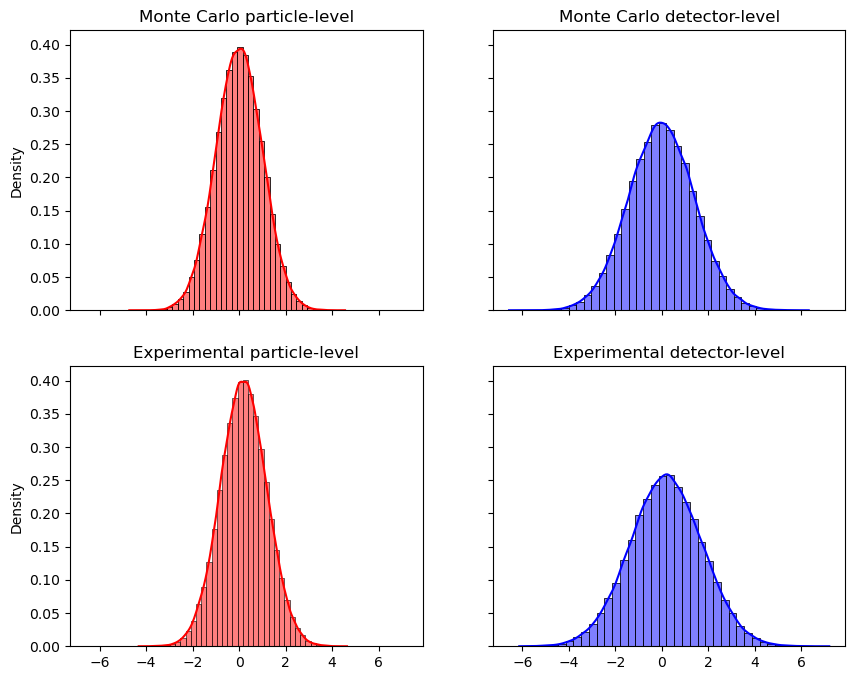

In [5]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 8))
sns.histplot(x_mc[:,0], kde=True, bins=40, ax=ax[0,0], stat = "density", color="r")
sns.histplot(y_mc[:,0], kde=True, bins=40, ax=ax[0,1], stat = "density", color="b")
sns.histplot(x_data[:,0], kde=True, bins=40, ax=ax[1,0], stat = "density", color="r")
sns.histplot(y_data[:,0], kde=True, bins=40, ax=ax[1,1], stat = "density", color="b")
ax[0,0].set_title("Monte Carlo particle-level")
ax[0,1].set_title("Monte Carlo detector-level")
ax[1,0].set_title("Experimental particle-level")
ax[1,1].set_title("Experimental detector-level")

# 2D Gaussian data

## Response kernel

In [ ]:
# smearing kernel for the MC data
mu_kernel_mc = 0
sigma1_kernel_mc = 1
sigma2_kernel_mc = 1

# smearing kernel for the experimental data
mu_kernel_data = 0
sigma1_kernel_data = 1
sigma2_kernel_data = 1.2

def k_mc(y,x):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_mc,scale=sigma1_kernel_mc)*norm.pdf(y[:,1]-x[:,0],loc=mu_kernel_mc,scale=sigma2_kernel_mc)

def k_data(y,x):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_data,scale=sigma1_kernel_data)*norm.pdf(y[:,1]-x[:,0],loc=mu_kernel_data,scale=sigma2_kernel_data)

# reweighting function w parametrized by theta (in this case, the standard deviation of the response kernel)
def w_theta(y,x,theta):
    return norm.pdf(y[:,0]-x[:,0],loc=mu_kernel_data,scale=sigma1_kernel_data)*norm.pdf(y[:,1]-x[:,0],loc=mu_kernel_data,scale=theta)/k_mc(y,x)

# derivative of w with respect to theta
def w_theta_derivative(y,x,theta):
    return ((y[:,1]-x[:,0])**2/(theta**3)-1/theta)*w_theta(y,x,theta)

# true reweighting function on the MC response kernel
def w_true(y,x):
    return k_data(y,x)/k_mc(y,x)

## Experimental particle-level and detector-level distribution

In [ ]:
mu_data = 0.8
sigma_data = 1

def px(x):
    return norm.pdf(x,loc=mu_data,scale=sigma_data)
def py1(y):
    return norm.pdf(y,loc=mu_data+mu_kernel_data,scale=np.sqrt(sigma_data**2+sigma1_kernel_data**2))
def py2(y):
    return norm.pdf(y,loc=mu_data+mu_kernel_data,scale=np.sqrt(sigma_data**2+sigma2_kernel_data**2))

# sample from the distribution
Ndata = 100000
x_data = np.random.normal(loc=mu_data,scale=sigma_data,size=Ndata).reshape(-1,1)
y_data1 = np.random.normal(loc=x_data[:,0]+mu_kernel_data,scale=sigma1_kernel_data,size=Ndata).reshape(-1,1)
y_data2 = np.random.normal(loc=x_data[:,0]+mu_kernel_data,scale=sigma2_kernel_data,size=Ndata).reshape(-1,1)
y_data = np.hstack([y_data1, y_data2])

## Monte Carlo particle-level and detector-level distribution

In [ ]:
mu_mc = 0
sigma_mc = 1


def qx(x):
    return norm.pdf(x,loc=mu_mc,scale=sigma_mc)
def qy1(y):
    return norm.pdf(y,loc=mu_mc+mu_kernel_mc,scale=np.sqrt(sigma_mc**2+sigma1_kernel_mc**2))
def qy2(y):
    return norm.pdf(y,loc=mu_mc+mu_kernel_mc,scale=np.sqrt(sigma_mc**2+sigma2_kernel_mc**2))


# sample from the distribution
Nsim = 100000
x_mc = np.random.normal(loc=mu_mc,scale=sigma_mc,size=Nsim).reshape(-1,1)
y_mc1 = np.random.normal(loc=x_mc[:,0]+mu_kernel_mc,scale=sigma1_kernel_mc,size=Nsim).reshape(-1,1)
y_mc2 = np.random.normal(loc=x_mc[:,0]+mu_kernel_mc,scale=sigma2_kernel_mc,size=Nsim).reshape(-1,1)
y_mc = np.hstack([y_mc1,y_mc2])

In [ ]:
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True, figsize=(10, 8))
sns.histplot(x_mc[:,0], kde=True, bins=40, ax=ax[0,0], stat = "density", color="r")
sns.histplot(y_mc1[:,0], kde=True, bins=40, ax=ax[0,1], stat = "density", color="b")
sns.histplot(y_mc2[:,0], kde=True, bins=40, ax=ax[0,2], stat = "density", color="b")
sns.histplot(x_data[:,0], kde=True, bins=40, ax=ax[1,0], stat = "density", color="r")
sns.histplot(y_data1[:,0], kde=True, bins=40, ax=ax[1,1], stat = "density", color="b")
sns.histplot(y_data2[:,0], kde=True, bins=40, ax=ax[1,2], stat = "density", color="b")
ax[0,0].set_title("Monte Carlo particle-level")
ax[0,1].set_title("Monte Carlo detector-level 1")
ax[0,2].set_title("Monte Carlo detector-level 2")
ax[1,0].set_title("Experimental particle-level")
ax[1,1].set_title("Experimental detector-level 1")
ax[1,2].set_title("Experimental detector-level 2")

# Steeply Falling Spectrum

## Response kernel

In [ ]:
# smearing kernel for the MC data
mu_kernel_mc = 0
sigma_kernel_mc = 25

# smearing kernel for the experimental data
mu_kernel_data = 0
sigma_kernel_data = 25


def k_mc(y,x):
    return norm.pdf(y-x,loc=mu_kernel_mc,scale=sigma_kernel_mc)

def k_data(y,x):
    return norm.pdf(y-x,loc=mu_kernel_data,scale=sigma_kernel_data)

# reweighting function on the MC response kernel
def w(y,x):
    return k_data(y,x)/k_mc(y,x)

# reweighting function w parametrized by theta (in this case, the standard deviation of the response kernel
def w_theta(y,x,theta):
    return norm.pdf(y-x,loc=mu_kernel_data,scale=theta)/k_mc(y,x)

# derivative of w with respect to theta
def w_theta_derivative(y,x,theta)
    return ((y[:,0]-x[:,0])**2/(theta**3)-1/theta)*w_theta(y,x,theta)

# true reweighting function on the MC response kernel
def w_true(y,x):
    return k_data(y,x)/k_mc(y,x)

## Experimental particle-level and detector-level distribution

In [ ]:
# parameters for the intensity function
L = 5.1
N0 = 1e17
alpha = 3.0
beta = 5.0
gamma = 5.0
s = (7000)**2

# bounds for true and smeared space
lb = 400
ub = 1000


def px(x):
    def fx(x):
        return L*N0*(x**(-alpha))*((1-2/np.sqrt(s)*x)**beta)*np.exp(-gamma/x)
    return fx(x)/quad(fx,lb,ub)[0]

# sample from px and py
Ndata = 100000
x_data = utils.rejection_sampling(Ndata,px,400,1000,1e5).reshape(-1,1)
y_data = np.random.normal(loc=x_data[:,0]+mu_kernel_data,scale=sigma_kernel_data,size=Ndata).reshape(-1,1)

## Monte Carlo particle-level and detector-level distribution

In [ ]:
# parameters for the intensity function
L = 5.1
N0 = 1e17
alpha_mc = 5.0
beta_mc = 10.0
gamma_mc = 10.0
s = (7000)**2

# bounds for true and smeared space
lb = 400
ub = 1000

def qx(x):
    def fx_mc(x):
        return L*N0*(x**(-alpha_mc))*((1-2/np.sqrt(s)*x)**beta_mc)*np.exp(-gamma_mc/x)
    return fx_mc(x)/quad(fx_mc,lb,ub)[0]

# sample from px and py
Nsim = 100000
x_mc = utils.rejection_sampling(Nsim,qx,400,1000,1e5).reshape(-1,1)
y_mc = np.random.normal(loc=x_mc[:,0]+mu_kernel_mc,scale=sigma_kernel_mc,size=Nsim).reshape(-1,1)

In [ ]:
fig, ax = plt.subplots(2, 2, sharey=True, sharex=True, figsize=(10, 8))
# x = np.linspace(-5, 5, 1000)
#ax[0].plot(x, px(x),
#       'r-', lw=3, alpha=0.6, label='Experimental particle-level')
#ax[1].plot(x, qx(x),
#       'b-', lw=3, alpha=0.6, label='Monte Carlo particle-level')
sns.histplot(x_mc[:,0], kde=True, bins=40, ax=ax[0,0], stat = "density", color="r")
sns.histplot(y_mc[:,0], kde=True, bins=40, ax=ax[0,1], stat = "density", color="b")
sns.histplot(x_data[:,0], kde=True, bins=40, ax=ax[1,0], stat = "density", color="r")
sns.histplot(y_data[:,0], kde=True, bins=40, ax=ax[1,1], stat = "density", color="b")
ax[0,0].set_title("Monte Carlo particle-level")
ax[0,1].set_title("Monte Carlo detector-level")
ax[1,0].set_title("Experimental particle-level")
ax[1,1].set_title("Experimental detector-level")

# Run omnifold (profile omnifold) algorithm

## Original omnifold (without profiling)

In [ ]:
# omnifold without NN (random forest instead)
nu_omni = utils.omnifold(y_data,x_mc,y_mc,10,save_iter=True)

In [ ]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model_omni = Model(inputs=inputs, outputs=outputs)

In [ ]:
# omnifold using NN
mc = np.stack([x_mc[:,0], y_mc[:,0]], axis=1)
nu_omni_nn = of.omnifold(mc, y_data[:,0], 10, model_omni, verbose=0)

## Nonparametric profile omnifold

In [ ]:
nu_np_profile = utils.nonparametric_profile_omnifold(y_data,x_mc,y_mc,10,save_iter=True)

In [ ]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model_np = Model(inputs=inputs, outputs=outputs)

In [ ]:
# nonparametric profile omnifold using NN
mc = np.stack([x_mc[:,0], y_mc[:,0]], axis=1)
nu_np_profile_nn = of.nonparametric_profile_omnifold(mc, y_data[:,0], 10, model_np, verbose=0)

## Parametric ($\theta$) profile omnifold

### Train the reweighting function $w(y,x,\theta)$

In [ ]:
# Generate toy data for w training

# simulation with theta variation (theta value randomly sampled)
#eps_min = 0.2
#eps_max = 1.8
eps_min = 15
eps_max = 40
epsilon0_sim = np.random.uniform(eps_min, eps_max, Nsim).reshape(-1, 1)
epsilon1_sim = np.random.uniform(eps_min, eps_max, Nsim).reshape(-1, 1) # used for training
delta_epsilon = (eps_max-eps_min)/np.sqrt(12)
theta0_sim = (epsilon0_sim-sigma_kernel_mc)/delta_epsilon
theta1_sim = (epsilon1_sim-sigma_kernel_mc)/delta_epsilon
y_sim = []
for i in range(Nsim):
    # use the x_mc to generate y_sim
    y_sim.append(np.random.normal(x_mc[i], epsilon1_sim[i,0]))
y_sim = np.array(y_sim)

In [ ]:
# First, train the model for w(y,x,theta)

# Convert data into W dataset, data loaders and create loss function
w_ds = of.w_dataset(x_mc, y_mc, theta0_sim, x_mc, y_sim, theta1_sim)
std_params = [
    x_mc.mean(),
    y_mc.std(),
    torch.from_numpy(np.concatenate((y_mc, y_sim)).mean(axis=0)).to(dvc),
    torch.from_numpy(np.concatenate((y_mc, y_sim)).std(axis=0)).to(dvc)
]
print(std_params)
# split samples to 50% train and 50% test sets
w_ds_train, w_ds_test = random_split(w_ds, [len(w_ds)//2, len(w_ds)-len(w_ds)//2])
w_dataloader_train = DataLoader(w_ds_train, batch_size=100000, shuffle=True, num_workers=12)
w_dataloader_test = DataLoader(w_ds_test, batch_size=100000, shuffle=False, num_workers=12)

In [ ]:
# Train W model

wRT_model_network = of.wRT_network(sigmoid=True, std_params=std_params, n_inputs=3).double().to(dvc)
optimizerRT = optim.Adam(wRT_model_network.parameters(), lr=0.001)
loss_fn_RT = nn.BCELoss()
wRT_tr = of.w_trainer(w_dataloader_train, w_dataloader_test, wRT_model_network, loss_fn_RT, optimizerRT)

wT_model_network = of.wT_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)
optimizerT = optim.Adam(wT_model_network.parameters(), lr=0.001)
loss_fn_T = nn.BCELoss()
wT_tr = of.w_trainer(w_dataloader_train, w_dataloader_test, wT_model_network, loss_fn_T, optimizerT)

wRT_tr.fit()
wT_tr.fit()

In [ ]:
# Save the model
torch.save(wRT_model_network.state_dict(), "results/wRT_network_steep")
torch.save(wT_model_network.state_dict(), "results/wT_network_steep")

# Load the model
#wRT_model_network = of.wRT_network(sigmoid=True, std_params=std_params, n_inputs=3).double().to(dvc)
#wT_model_network = of.wT_network(sigmoid=True, std_params=std_params, n_inputs=2).double().to(dvc)

#wRT_model_network.load_state_dict(torch.load("results/wRT_network_steep"))
#wT_model_network.load_state_dict(torch.load("results/wT_network_steep"))

In [ ]:
# Test the trained W1 model
Ntest = 100000
epsilon_test = 30
theta_test = (epsilon_test-sigma_kernel_mc)/delta_epsilon
x_test = x_data.reshape(-1, 1)
y_test0 = np.random.normal(x_test,sigma_kernel_mc)
y_test1 = np.random.normal(x_test,epsilon_test)


w_test_ds = of.test_dataset(x_test, y_test0)
w_test_dataloader = DataLoader(w_test_ds, batch_size=64, shuffle=False, num_workers=12)

Ts_0, Rs_0, Ws_0 = of.test_w(w_test_dataloader, wRT_model_network, wT_model_network, theta_test)
Ts_0, Rs_0, Ws_0 = Ts_0.cpu().numpy(), Rs_0.cpu().numpy(), Ws_0.cpu().numpy()


cpwr = utils.comparison_plots_with_ratio(300, 1000, 80, xlabel=r"$R$", density=True)
cpwr.add_data(y_data, label=r"Sim ($\epsilon=1.2$)", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(Rs_0[:,0], label=r"Sim ($\epsilon=1$)", alpha=0.5, color='tab:blue')
cpwr.add_data(Rs_0[:,0], weights=Ws_0, label="Sim (W1 rw.)", alpha=0.5, color='tab:orange')
cpwr.show()
print("true Theta:", theta_test)

In [ ]:
# Fitting w function parametrized by theta on the Monte Carlo data
ds = of.test_dataset(x_mc, y_mc)
ds_dataloader = DataLoader(ds, batch_size=1024, shuffle=False, num_workers=12)
w_func = of.make_w_func(ds_dataloader, wRT_model_network, wT_model_network)

In [ ]:
#inputs = Input((1, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

#model_profile_omni = Model(inputs=inputs, outputs=outputs)
#model_profile_omni.summary()



#class ProfileModel(Model):
#    def __init__(self):
#        super(ProfileModel, self).__init__()
#        self.theta = tf.Variable(1.0, dtype=tf.float32, name='theta', trainable=True)
#        self.dense1 = Dense(50, activation='relu')
#        self.dense2 = Dense(50, activation='relu')
#        self.dense3 = Dense(50, activation='relu')
#        self.output_layer = Dense(1, activation='sigmoid')
    
#    def call(self, inputs):
#        x = self.dense1(inputs)
#        x = self.dense2(x)
#        x = self.dense3(x)
#        return self.output_layer(x)
    
#    def get_theta(self):
#        return self.theta




#inputs = Input((1, ))
#hidden_layer_1 = Dense(50, activation='relu')(inputs)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
#model_profile_omni = ProfileModel()

#model_profile_omni.summary()




    #    self.dense1 = tf.keras.layers.Dense(50, activation='relu')
    #    self.dense2 = tf.keras.layers.Dense(50, activation='relu')
    #    self.dense3 = tf.keras.layers.Dense(50, activation='relu')
    #    self.softmax = tf.keras.layers.Dense(1, activation='sigmoid')

    #def call(self, inputs):
    #    x = self.dense1(inputs)
    #    x = self.dense2(x)
    #    x = self.dense3(x)
    #    return self.softmax(x)

# Define the input shape
#input_shape = (None, 1)  # For example, (batch_size, number_of_features)
# Create an input layer with the specified shape
#inputs = tf.keras.Input(shape=input_shape[1:])
# Pass the input tensor to the model
#outputs = model(inputs)
# Create a model using inputs and outputs
#model_profile_omni = tf.keras.Model(inputs, outputs)


#def manual_initializer(shape, dtype=None):
#    return 0.25

#class ThetaLayer(tf.keras.layers.Layer):
#    def __init__(self):
#        super(ThetaLayer, self).__init__()
#        self.theta = self.add_weight(
#            shape=(),  # Scalar
#            initializer=manual_initializer,
#            trainable=True,
#            name='theta'
#        )
    
#    def call(self, inputs):
#        return self.theta * inputs

#@tf.keras.utils.register_keras_serializable()
#class ProfileModel(Model):
#    def __init__(self):
#        super(ProfileModel, self).__init__()
#        self.theta_layer = ThetaLayer()
#        self.concatenate = Concatenate()
#        self.dense1 = Dense(50, activation='relu')
#        self.dense2 = Dense(50, activation='relu')
#        self.dense3 = Dense(50, activation='relu')
#        self.output_layer = Dense(1, activation='sigmoid')
    
#    def call(self, inputs):
#        #x = self.concatenate([inputs, self.theta_layer(tf.constant([1.]))])
#        x = self.concatenate([inputs, self.theta_layer(tf.ones_like(inputs))])
#        x = self.dense1(x)
#        x = self.dense2(x)
#        x = self.dense3(x)
#        return self.output_layer(x)
    
#    def get_theta(self):
#        return self.theta_layer.theta

#model = ProfileModel()
#model.get_theta().numpy()
#model.summary()

#inputs = Input(shape=(1,))
#outputs = model(inputs)
#model_profile_omni = Model(inputs, outputs)
#model_profile_omni.summary()
#model_profile_omni.layers[1].trainable_weights[0].numpy()

In [ ]:
#This is a bit of a hack, but basically, theta is now a tensor internal to the network instead of an input by the user.
#inputs_hold = Input(shape=(1,))
#simple_model = Dense(1,use_bias = False,activation='linear',kernel_initializer=tf.keras.initializers.Constant(0.5))(inputs_hold)
#model = Model(inputs = inputs_hold, outputs = simple_model)

#def manual_initializer(shape, dtype=None):
#    return 0.3

#class ThetaLayer(tf.keras.layers.Layer):
#    def __init__(self):
#        super(ThetaLayer, self).__init__()
#        self.theta = self.add_weight(
#            shape=(),  # Scalar
#            initializer=manual_initializer,
#            trainable=True,
#            name='theta'
#        )
    
#    def call(self, inputs):
#        return self.theta * tf.ones_like(inputs)


#inputs = Input(shape=(1,))
#inputs2 = tf.keras.layers.concatenate([inputs,ThetaLayer()(inputs)])
#hidden_layer_1 = Dense(50, activation='relu')(inputs2)
#hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
#hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
#outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

#model_profile_omni = Model(inputs=inputs, outputs=outputs)
#print(model_profile_omni.layers[1].trainable_weights[0].numpy())
#model_profile_omni.summary()

In [ ]:
#mc = np.stack([x_mc[:,0], y_mc[:,0]], axis=1)

#nu_profile_omni_nn = of.profile_omnifold2(mc, y_data[:,0], 5, model_profile_omni, w_func, 0, verbose=1)

In [ ]:
# Save the model
#model_profile_omni.save("results/penalized_profile_omnifold_network.keras")

# load the model
#model_profile_omni = tf.keras.models.load_model('results/penalized_profile_omnifold_network.keras')

In [ ]:
#loaded_model = tf.keras.models.load_model(
#    'results/penalized_profile_omnifold_network.keras',
#    custom_objects={'ProfileModel': ProfileModel}
#)

In [6]:
# Or if known, we can choose to use the true w function parametrized by theta
delta_epsilon = 1.5
theta_test = (sigma_kernel_data-sigma_kernel_mc)/delta_epsilon
def w_func(theta):
    return w_theta(y_mc, x_mc, theta*delta_epsilon+sigma_kernel_mc)
def w_func_derivative(theta):
    return w_theta_derivative(y_mc, x_mc, theta*delta_epsilon+sigma_kernel_mc)

In [7]:
theta_test

0.1333333333333333

### Penalized profile omnifold

In [ ]:
nu_profile_penalized_ad_hoc = utils.ad_hoc_penalized_profile_omnifold(y_data,x_mc,y_mc,theta_bar=0.,theta0=0.,
                                                        w_func=w_func,niter=10,save_iter=True)


ITERATION: 1

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [0.95013468 0.90717887 0.91878031 ... 1.27109987 0.96250292 1.03047362] 

Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.99366036 0.89694334 0.99321002 ... 0.94070625 0.896247   0.91056689] 

Value of Theta before update: 0.0
Updated theta: 0.032173355623461304

ITERATION: 2

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [0.96735061 0.93752386 0.96162105 ... 1.11562055 0.96735061 1.10159531] 

Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.9662043  0.8647251  0.9679828  ... 0.91449888 0.86405378 0.89965506] 

Value of Theta before update: 0.032173355623461304
Updated theta: 0.047534754930535314

ITERATION: 3

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [0.98490873 0.99592584 0.98092047 ... 1.03418806 0.98456382 1.0441714 ] 

Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.95109421 0.86359997 0.96487584 ... 

In [18]:
nu_profile_penalized = utils.penalized_profile_omnifold(y_data,x_mc,y_mc,theta_bar=0.,theta0=0.,
                                                        w_func=w_func,w_func_derivative=w_func_derivative,niter=10,save_iter=True)


ITERATION: 1

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [0.87941413 0.95891847 0.877812   ... 1.55051591 1.02533624 1.07800198] 

Value of Theta before update: 0.0
Updated theta: 0.03406138233815236
Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.91542293 0.90820662 0.89617044 ... 1.12698302 1.11295948 0.9608647 ] 


ITERATION: 2

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [0.958448   0.95918175 0.94990987 ... 1.18863429 1.05054322 1.00876948] 

Value of Theta before update: 0.03406138233815236
Updated theta: 0.041403323166795084
Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.90390797 0.89702868 0.88968279 ... 1.19554267 1.19162449 0.94609667] 


ITERATION: 3

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [0.97546409 0.97539051 0.96800172 ... 1.14693493 0.97089155 0.92034073] 

Value of Theta before update: 0.041403323166795084
Updated theta: 0.03913222073428234
Fitting pull-ba

In [ ]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model_penalized_ad_hoc = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Method using NN
mc = np.stack([x_mc[:,0], y_mc[:,0]], axis=1)
nu_profile_penalized_ad_hoc_nn = of.ad_hoc_penalized_profile_omnifold(mc, y_data[:,0], 10, model_penalized_ad_hoc, w_func, 0., 0., verbose=1)

In [ ]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model_penalized = Model(inputs=inputs, outputs=outputs)

In [ ]:
# Method using NN
mc = np.stack([x_mc[:,0], y_mc[:,0]], axis=1)
nu_profile_penalized_nn = of.penalized_profile_omnifold(mc, y_data[:,0], 10, model_penalized, w_func, w_func_derivative, 0., 0., verbose=1)

### Profile omnifold with known nuisance parameter

In [ ]:
# W function evalauted at the true nuisance parameter
w = w_func(theta_test)
if isinstance(w, torch.Tensor):
    w = w.cpu().numpy().flatten()

In [6]:
# true W function based on the known analytical form
w = w_true(y_mc,x_mc)

In [7]:
# Method without NN
nu_profile_known = utils.profile_omnifold_known_nuisance(y_data,x_mc,y_mc,w,10,save_iter=True)


ITERATION: 1

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [1.00929932 1.02551106 1.04572427 ... 1.21479713 1.12362441 1.11161991] 

Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.97108289 0.97457647 0.97496707 ... 1.08591104 1.05923868 1.0489898 ] 


ITERATION: 2

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [1.01777177 1.02513855 0.95472239 ... 1.11831301 1.06404133 1.06362519] 

Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.95468702 0.95739844 0.98117922 ... 1.13898629 1.10650974 1.06530682] 


ITERATION: 3

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [1.00101173 1.00063456 0.97948172 ... 1.07391219 1.00632649 1.00551369] 

Fitting pull-back weights on x_mc...
updated weight on x_mc: [0.93915958 0.93881573 0.9754154  ... 1.15345558 1.12023203 1.0767864 ] 


ITERATION: 4

Fitting push-forward weights on y_mc...
updated ratio of y_mc/y_exp: [1.00352183 1.00976315 0.96487722 ...

In [8]:
inputs = Input((1, ))
hidden_layer_1 = Dense(50, activation='relu')(inputs)
hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
outputs = Dense(1, activation='sigmoid')(hidden_layer_3)

model_profile_known = Model(inputs=inputs, outputs=outputs)

2024-08-14 20:21:01.116036: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 79099 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2024-08-14 20:21:01.117603: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 79099 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2024-08-14 20:21:01.118984: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 79099 MB memory:  -> device: 2, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:82:00.0, compute capability: 8.0
2024-08-14 20:21:01.120489: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 79099 MB memory:  -> device: 3, name: NVIDIA A100-SXM4-80GB, pci bu

In [9]:
# Method using NN
mc = np.stack([x_mc[:,0], y_mc[:,0]], axis=1)
nu_profile_known_nn = of.profile_omnifold_known_nuisance(mc, y_data[:,0], 10, model_profile_known, w, verbose=0)

/pscratch/sd/r/richardz/local/miniconda/envs/unfolding-tensorflow/lib/python3.11/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


## Results

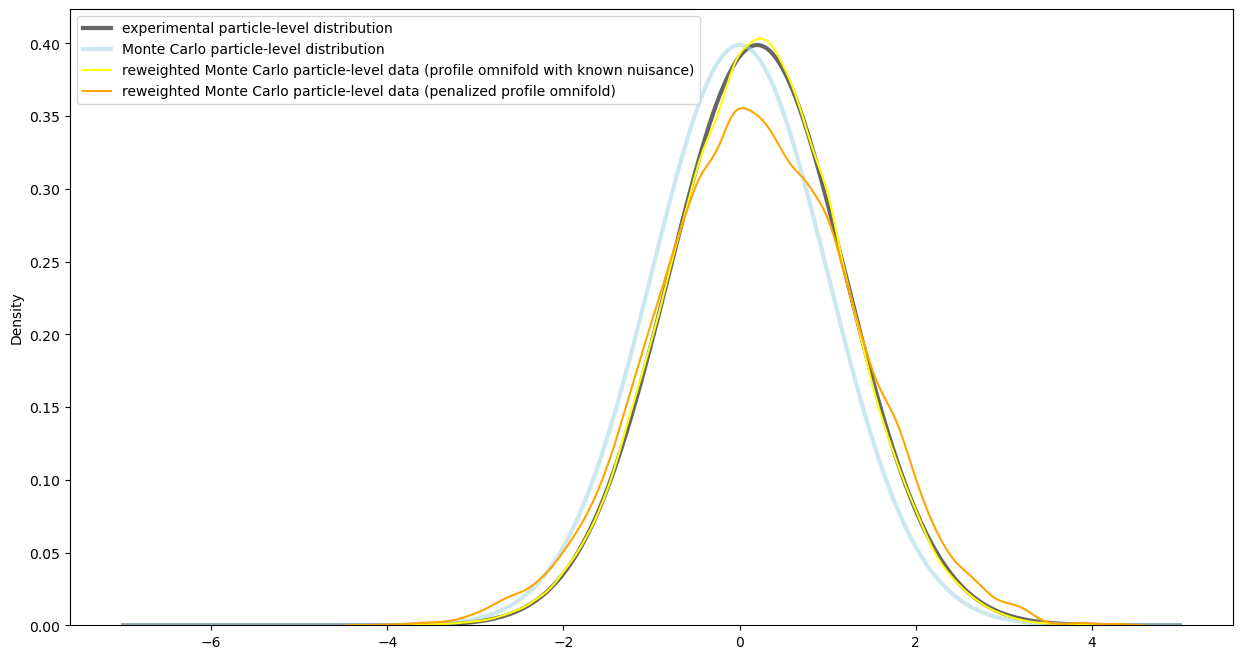

In [31]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(15, 8))
x = np.linspace(-7, 5, 1000)
ax.plot(x, px(x),
       'black', lw=3, alpha=0.6, label='experimental particle-level distribution')
ax.plot(x, qx(x),
       'lightblue', lw=3, alpha=0.6, label='Monte Carlo particle-level distribution')
#sns.kdeplot(x=x_mc[:,0], ax=ax, color="b", weights=nu_omni[4,1,:],label='reweighted Monte Carlo particle-level data (omnifold)')
sns.kdeplot(x=x_mc[:,0], ax=ax, color="yellow", weights=nu_profile_known_nn[7,1,:], label='reweighted Monte Carlo particle-level data (profile omnifold with known nuisance)')
#sns.kdeplot(x=x_mc[:,0], ax=ax, color="g", weights=nu_np_profile[5,1,:], label='reweighted Monte Carlo particle-level data (nonparametric profile omnifold)')
sns.kdeplot(x=x_mc[:,0], ax=ax, color="orange", weights=nu_profile_penalized[4,1,:], label='reweighted Monte Carlo particle-level data (penalized profile omnifold)')
#sns.kdeplot(x=x_mc[:,0], ax=ax, color="brown", weights=nu_profile_penalized_ad_hoc[4,1,:], label='reweighted Monte Carlo particle-level data (ad-hoc penalized profile omnifold)')
#sns.kdeplot(x=x_mc[:,0], ax=ax, color="purple", weights=nu_profile_half_unbinned, label='reweighted Monte Carlo particle-level data (half unbinned profile unfolding)')
plt.legend(loc='best')

In [ ]:
fig, ax = plt.subplots(1, 1, sharey=True, sharex=True, figsize=(15, 8))
x = np.linspace(400, 1000, 1000)
#ax.plot(x, py(x),
#       'black', lw=3, alpha=0.6, label='experimental detector-level distribution')
#ax.plot(x, qy(x),
#       'lightblue', lw=3, alpha=0.6, label='Monte Carlo detector-level distribution')
sns.kdeplot(x=y_mc[:,0], ax=ax, color="black", label='experimental detector-level distribution')
#sns.kdeplot(x=y_data[:,0], ax=ax, color="lightblue", label='Monte Carlo detector-level distribution')
#sns.kdeplot(x=y_mc[:,0], ax=ax, color="b", weights=nu_omni[2,1,:],label='reweighted Monte Carlo detector-level data (omnifold)')
sns.kdeplot(x=y_mc[:,0], ax=ax, color="yellow", weights=nu_profile_known[4,1,:]*nu_profile_known[4,2,:], label='reweighted Monte Carlo detector-level data (profile omnifold with known nuisance)')
sns.kdeplot(x=y_mc[:,0], ax=ax, color="g", weights=nu_np_profile[4,1,:]*nu_np_profile[4,2,:], label='reweighted Monte Carlo detector-level data (nonparametric profile omnifold)')
sns.kdeplot(x=y_mc[:,0], ax=ax, color="orange", weights=nu_profile_penalized[4,1,:]*nu_profile_penalized[4,2,:], label='reweighted Monte Carlo detector-level data (penalized profile omnifold)')
#sns.kdeplot(x=y_mc[:,0], ax=ax, color="purple", weights=nu_profile_half_unbinned*w_profile_half_unbinned, label='reweighted Monte Carlo detector-level data (half unbinned profile unfolding)')
plt.legend(loc='best')

In [ ]:
cpwr = utils.comparison_plots_with_ratio(-7, 5, 80, xlabel=r"$T$", density=True, header="Gaussian 1D example")
cpwr.add_data(x_data, label="experimental particle-level distribution", target=True, color='black', histtype="step", ls="-", lw=1.4)
cpwr.add_data(x_mc, label="Monte Carlo particle-level distribution", alpha=0.5, color='lightblue')
cpwr.add_data(x_mc, weights=nu_omni_nn[5,1,:], label="omnifold", alpha=0.5, color='b')
#cpwr.add_data(x_mc, weights=nu_profile_known_nn[5,1,:], label="profile omnifold with known nuisance", alpha=0.5, color='yellow')
#cpwr.add_data(x_mc, weights=nu_np_profile_nn[4,1,:], label="nonparametric profile omnifold", alpha=0.5, color='green')
#cpwr.add_data(x_mc, weights=nu_profile_penalized_nn[4,1,:], label="penalized profile omnifold", alpha=0.5, color='orange')
#cpwr.add_data(x_mc, weights=nu_profile_half_unbinned, label="half unbinned profile unfolding", alpha=0.5, color='purple')
cpwr.show()

In [ ]:
# For further reference, store the weights from different methods into pickle file

# Saving the weights:
#with open('results/weights_fitted_w.pkl', 'wb') as f:
#    pickle.dump([x_mc, y_mc, x_data, y_data, nu_omni_nn, nu_np_profile_nn, nu_profile_known_nn, nu_profile_penalized_nn, nu_profile_half_unbinned, w_profile_half_unbinned], f)

In [ ]:
# Saving the weights:
#with open('results/weights_steep_no_nuisance.pkl', 'wb') as f:
#    pickle.dump([x_mc, y_mc, x_data, y_data, nu_omni, nu_omni_nn], f)

In [ ]:
# Saving the weights:
with open('results/weights_2dgaussian_nuisance.pkl', 'wb') as f:
    pickle.dump([x_mc, y_mc, x_data, y_data, nu_omni, nu_omni_nn, nu_np_profile, nu_np_profile_nn, 
                 nu_profile_known, nu_profile_known_nn, nu_profile_penalized_ad_hoc, nu_profile_penalized_ad_hoc_nn, nu_profile_penalized, nu_profile_penalized_nn], f)

In [ ]:
# Getting back the weights:
with open('results/weights_steep_no_nuisance.pkl', 'rb') as f:
    x_mc, y_mc, x_data, y_data, nu_omni, nu_omni_nn = pickle.load(f)

In [ ]:
# Getting back the weights:
with open('results/weights_gaussian_nuisance.pkl', 'rb') as f:
    x_mc, y_mc, x_data, y_data, nu_omni, nu_omni_nn, nu_np_profile, nu_np_profile_nn, nu_profile_known, nu_profile_known_nn, nu_profile_penalized_ad_hoc, nu_profile_penalized_ad_hoc_nn, nu_profile_penalized, nu_profile_penalized_nn = pickle.load(f)

In [ ]:
# Getting back the weights:
with open('results/weights.pkl', 'rb') as f:
    x_mc, y_mc, x_data, y_data, nu_omni, nu_omni_nn, nu_profile, nu_profile_omni_nn = pickle.load(f)

In [ ]:
# Getting back the weights:
with open('results/weights_fitted_w.pkl', 'rb') as f:
    x_mc, y_mc, x_data, y_data, nu_omni_nn, nu_np_profile_nn, nu_profile_known_nn, nu_profile_penalized_nn, nu_profile_half_unbinned, w_profile_half_unbinned = pickle.load(f)